<a href="https://colab.research.google.com/github/artsasse/fedkan/blob/main/Flower_MNIST_MLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Using a Federated MLP to classify MNIST

This notebook is based mainly on the Flower Tutorial "Use a federated learning strategy", found in https://flower.ai/docs/framework/tutorial-series-use-a-federated-learning-strategy-pytorch.html .

## Global Values

In [1]:
NUM_PARTITIONS = 100
BATCH_SIZE = 100
LOCAL_EPOCHS = 1
FRACTION_CLIENTS = 0.1
COMM_ROUNDS = 3
NET_TYPE = "mlp"
LEARNING_RATE = 0.1
MOMENTUM = 0.9
HISTORY = {}
TRY_DEVICE = "cpu"
SEED = 1

## Dependencies

In [2]:
pip install -q flwr[simulation] flwr-datasets[vision] torch torchvision

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.1/65.1 MB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 MB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.9/3.9 MB 35.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.1/542.1 kB 23.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.0/172.0 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 34.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 26.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 464.4/464.4 kB 13.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.0/73.0 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/1

In [5]:
# Efficient KAN
!pip install -q git+https://github.com/Blealtan/efficient-kan.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 341.8/341.8 kB 7.0 MB/s eta 0:00:00


In [6]:
from collections import OrderedDict
from typing import Dict, List, Optional, Tuple

import random
import os
from logging import INFO

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

import flwr
from flwr.client import Client, ClientApp, NumPyClient
from flwr.server import ServerApp, ServerConfig, ServerAppComponents, SimpleClientManager
from flwr.server.strategy import FedAvg, FedAdagrad
from flwr.simulation import run_simulation, start_simulation
from flwr_datasets import FederatedDataset
from flwr_datasets.partitioner import PathologicalPartitioner
from flwr_datasets.visualization import plot_label_distributions
from flwr.common import ndarrays_to_parameters, NDArrays, Scalar, Context, Metrics
from flwr.common.logger import log
from flwr.server.client_proxy import ClientProxy
from flwr.server.criterion import Criterion

from efficient_kan import KAN

DEVICE = torch.device(TRY_DEVICE)  # "cpu" or "cuda" ("mps" for Apple Silicon)
print(f"Training on {DEVICE}")
print(f"Flower {flwr.__version__} / PyTorch {torch.__version__}")

Training on cpu
Flower 1.11.0 / PyTorch 2.4.0+cu121


## Configuring Seeds

In [7]:
torch.manual_seed(SEED)
random.seed(SEED)
np.random.seed(SEED)
os.environ["PYTHONHASHSEED"] = str(SEED)
# torch.use_deterministic_algorithms(True)
# torch.backends.cudnn.benchmark = False
# torch.backends.cudnn.deterministic = True

## Data loading

In [8]:
def create_flower_dataset():

    # Like FedProx partition, but clients have similar number of examples
    partitioner = PathologicalPartitioner(
        num_partitions=NUM_PARTITIONS,
        partition_by="label",
        num_classes_per_partition=2,
        shuffle=True,
        seed=SEED
        )

    fds = FederatedDataset(
        dataset="mnist",
        partitioners={"train": partitioner},
        shuffle=True,
        seed=SEED
        )

    return fds

In [9]:
def load_datasets(partition_id: int, num_partitions: int):

    pytorch_transforms = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.5,), (0.5,)),
         transforms.Lambda(lambda x: torch.flatten(x))  # Flatten the image into a 1D tensor
         ]
    )

    def apply_transforms(batch):
        batch["image"] = [pytorch_transforms(img) for img in batch["image"]]
        return batch

    fds = create_flower_dataset()

    partition = fds.load_partition(partition_id).with_transform(apply_transforms)
    trainloader = DataLoader(partition, batch_size=BATCH_SIZE, shuffle=True,
                            #  worker_init_fn=seed_worker, generator=g
                             )

    testset = fds.load_split("test").with_transform(apply_transforms)
    testloader = DataLoader(testset, batch_size=BATCH_SIZE,
                            # worker_init_fn=seed_worker, generator=g
                            )

    return trainloader, testloader

### Partition Visualization

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/60000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

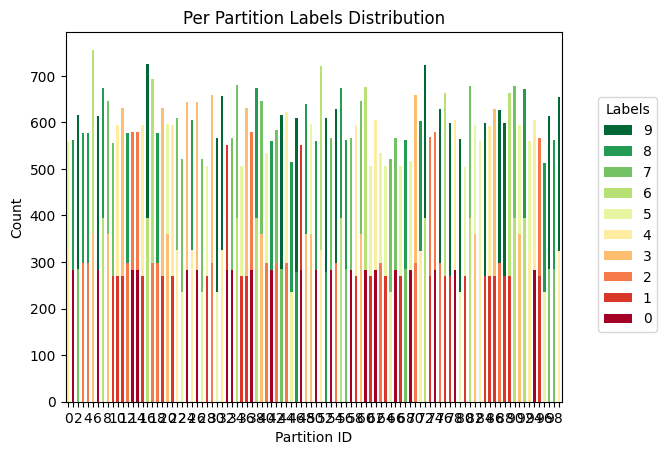

In [10]:
visual_fds = create_flower_dataset()
visual_partitioner = visual_fds.partitioners["train"]
fig, ax, df = plot_label_distributions(
    visual_partitioner,
    label_name="label",
    plot_type="bar",
    size_unit="absolute",
    partition_id_axis="x",
    legend=True,
    verbose_labels=True,
    title="Per Partition Labels Distribution",
)

In [11]:
df

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,0,1,2,3,4,5,6,7,8,9
Partition ID,,,,,,,,,,
0,0,0,0,0,325,236,0,0,0,0
1,283,0,0,0,0,0,0,0,279,0
2,0,0,0,0,0,0,0,285,0,331
3,0,0,298,0,0,0,0,0,279,0
4,0,0,298,0,0,0,0,0,279,0
...,...,...,...,...,...,...,...,...,...,...
95,0,269,297,0,0,0,0,0,0,0
96,0,0,0,0,0,235,0,0,278,0
97,0,0,0,0,0,0,0,284,0,330


## Model training/evaluation (PyTorch)

In [12]:
class MLPNet(nn.Module):

    def __init__(self) -> None:
        super(MLPNet, self).__init__()
        self.layer1 = nn.Linear(28 * 28, 200)  # 28 x 28 pixels
        self.layer2 = nn.Linear(200, 200)  # 2 hidden layers with 200 neurons each
        self.layer3 = nn.Linear(200, 10)  # 10 classes
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.relu(self.layer1(x))
        x = self.relu(self.layer2(x))
        x = self.softmax(self.layer3(x))
        return x

class KANNet(KAN):
    def __init__(self) -> None:
        super().__init__([28 * 28, 24, 24, 10])

def create_network(net_type: str = NET_TYPE):
    if net_type == "mlp":
        return MLPNet()
    elif net_type == "kan":
        return KANNet()
    else:
        raise ValueError(f"Unknown network type: {net_type}")

def get_parameters(net) -> List[np.ndarray]:
    return [val.cpu().numpy() for _, val in net.state_dict().items()]


def set_parameters(net, parameters: List[np.ndarray]):
    params_dict = zip(net.state_dict().keys(), parameters)
    state_dict = OrderedDict({k: torch.Tensor(v) for k, v in params_dict})
    net.load_state_dict(state_dict, strict=True)


def train(net, trainloader, epochs: int):
    """Train the network on the training set."""
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(
        net.parameters(),
        lr=LEARNING_RATE,
        momentum=MOMENTUM)
    net.train()
    for epoch in range(epochs):
        correct, total, epoch_loss = 0, 0, 0.0
        for batch in trainloader:
            images, labels = batch["image"], batch["label"]
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            outputs = net(images)
            loss = criterion(net(images), labels)
            loss.backward()
            optimizer.step()
            # Metrics
            epoch_loss += loss
            total += labels.size(0)
            correct += (torch.max(outputs.data, 1)[1] == labels).sum().item()
        epoch_loss /= len(trainloader.dataset)
        epoch_acc = correct / total
        print(f"Epoch {epoch+1}: train loss {epoch_loss}, accuracy {epoch_acc}")
        return epoch_loss, epoch_acc


def test(net, testloader):
    """Evaluate the network on the entire test set."""
    criterion = torch.nn.CrossEntropyLoss()
    correct, total, loss = 0, 0, 0.0
    net.eval()
    with torch.no_grad():
        for batch in testloader:
            images, labels = batch["image"], batch["label"]
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = net(images)
            loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    loss /= len(testloader.dataset)
    accuracy = correct / total
    return loss, accuracy

## Flower Architecture

### Flower client

In [13]:
class FlowerClient(NumPyClient):
    def __init__(self, pid, net, trainloader, valloader=None):
        self.pid = pid  # partition ID of a client
        self.net = net
        self.trainloader = trainloader
        self.valloader = valloader

    def get_parameters(self, config):
        print(f"[Client {self.pid}] get_parameters")
        return get_parameters(self.net)

    def fit(self, parameters, config):
        # Read values from config
        server_round = config["server_round"]
        local_epochs = config["local_epochs"]

        # Use values provided by the config
        print(f"[Client {self.pid}, round {server_round}] fit, config: {config}")
        set_parameters(self.net, parameters)
        epoch_loss, epoch_accuracy = train(self.net, self.trainloader, epochs=local_epochs)
        return get_parameters(self.net), len(self.trainloader), {"epoch_loss": float(epoch_loss),
                                                                 "epoch_accuracy": float(epoch_accuracy)}

    def evaluate(self, parameters, config):
        print(f"[Client {self.pid}] evaluate, config: {config}")
        set_parameters(self.net, parameters)
        loss, accuracy = test(self.net, self.valloader)
        return float(loss), len(self.valloader), {"accuracy": float(accuracy)}


def client_fn(context: Context) -> Client:
    net = create_network().to(DEVICE)
    partition_id = context.node_config["partition-id"]
    num_partitions = context.node_config["num-partitions"]
    trainloader, _ = load_datasets(partition_id, num_partitions)
    return FlowerClient(partition_id, net, trainloader).to_client()

### Server-side parameter **evaluation**

#### Save evaluation results

In [14]:
def create_new_history():
    history = {"net_type": NET_TYPE,
              "test_accuracy": [],
              "test_loss": [],
              "train_accuracy": [0.0], # No fit metrics before the first round
              "train_loss": [0.0],
              "execution_time": 0,
              "seed": SEED,
              "batch_size": BATCH_SIZE,
              "local_epochs": LOCAL_EPOCHS,
              "fraction_clients": FRACTION_CLIENTS,
              "comm_rounds": COMM_ROUNDS,
              "num_partitions": NUM_PARTITIONS,
              "device": DEVICE,
              "learning_rate": LEARNING_RATE,
              "momentum": MOMENTUM,
              }
    return history

# Need to use a global var because we can't pass our dictionary as argument
def save_test_metrics(server_round: int, accuracy: float, loss: float):
    HISTORY["test_accuracy"].append((accuracy, server_round))
    HISTORY["test_loss"].append((loss, server_round))

# Currently can't capture the server round inside the fit aggregation function
def save_train_metrics(accuracy: float, loss: float):
    HISTORY["train_accuracy"].append(accuracy)
    HISTORY["train_loss"].append(loss)

def save_execution_time(execution_time: float):
    HISTORY["execution_time"] = execution_time

#### Evaluation function

In [15]:
# The `evaluate` function will be called by Flower after every round
def evaluate(
    server_round: int,
    parameters: NDArrays,
    config: Dict[str, Scalar],
) -> Optional[Tuple[float, Dict[str, Scalar]]]:
    net = create_network().to(DEVICE)
    _, testloader = load_datasets(0, NUM_PARTITIONS)
    set_parameters(net, parameters)  # Update model with the latest parameters
    loss, accuracy = test(net, testloader)
    print(f"Server-side evaluation loss {loss} / accuracy {accuracy}")
    save_test_metrics(server_round, accuracy, loss)
    return loss, {"accuracy": accuracy}

### Training **Configuration** (e.g. epochs)




In [16]:
def fit_config(server_round: int):
    """Return training configuration dict for each round.

    """
    config = {
        "server_round": server_round,  # The current round of federated learning
        "local_epochs": LOCAL_EPOCHS,
    }
    return config

### Flower **Server**

#### Fit (training) Metrics Aggregation

In [17]:
def weighted_average(metrics: List[Tuple[int, Metrics]]) -> Metrics:
    """Inspired by https://github.com/adap/flower/blob/0e7c1b06c32ab90e0d3cf64825ed51eedd715509/examples/custom-mods/server.py"""

    # Get number of examples for each client used for training
    examples = [num_examples for num_examples, _ in metrics]

    # Multiply accuracy of each client by number of examples used
    train_losses = [
        num_examples * float(m["epoch_loss"]) for num_examples, m in metrics
    ]
    train_accuracies = [
        num_examples * float(m["epoch_accuracy"]) for num_examples, m in metrics
    ]

    train_loss = sum(train_losses) / sum(examples)
    train_accuracy = sum(train_accuracies) / sum(examples)

    save_train_metrics(train_accuracy, train_loss)

    # Aggregate and return custom metric (weighted average)
    return {
        "train_loss": sum(train_losses) / sum(examples),
        "train_accuracy": sum(train_accuracies) / sum(examples),
    }

#### Server function

In [18]:
def server_fn(context: Context) -> ServerAppComponents:
    # Create FedAvg strategy
    strategy = FedAvg(
        fraction_fit=FRACTION_CLIENTS,
        fraction_evaluate=0,
        min_fit_clients=1,
        min_evaluate_clients=0,
        min_available_clients=NUM_PARTITIONS,
        initial_parameters=ndarrays_to_parameters(params),
        evaluate_fn=evaluate,
        on_fit_config_fn=fit_config,
        fit_metrics_aggregation_fn=weighted_average,
    )

    config = ServerConfig(num_rounds=COMM_ROUNDS)
    return ServerAppComponents(strategy=strategy, config=config)

## Simulation

### Global model **initialization**

In [19]:
# Create an instance of the model and get the parameters
initial_model = create_network()
params = get_parameters(initial_model)
total_params = sum(p.numel() for p in initial_model.parameters() if p.requires_grad)
print(f"Total number of parameters: {total_params}")

Total number of parameters: 199210


### Run Simulation 1

In [20]:
# Define hardware resources
if DEVICE.type == "cuda":
    backend_config = {"client_resources": {"num_gpus": 0.25, "num_cpus": 2}}
else:
    backend_config = {"num_cpus": 2}

# Create Apps
client = ClientApp(client_fn=client_fn)
server = ServerApp(server_fn=server_fn)

# create new history
HISTORY = create_new_history()

# Run simulation
run_simulation(
    server_app=server,
    client_app=client,
    num_supernodes=NUM_PARTITIONS,
    backend_config=backend_config,
)

DEBUG:flwr:Asyncio event loop already running.
INFO :      Starting Flower ServerApp, config: num_rounds=3, no round_timeout
INFO :      
INFO :      [INIT]
INFO :      Using initial global parameters provided by strategy
INFO :      Starting evaluation of initial global parameters
/usr/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(
(pid=3096) 2024-09-08 19:53:34.200207: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(pid=3096) 2024-09-08 19:53:34.240257: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(pid=3096) 2024-09-08 19:53:34.251934:

Server-side evaluation loss 0.023028088164329528 / accuracy 0.112


(pid=3096) 2024-09-08 19:53:36.324152: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(ClientAppActor pid=3096) /usr/local/lib/python3.10/dist-packages/jupyter_client/connect.py:28: DeprecationWarning: Jupyter is migrating its paths to use standard platformdirs
(ClientAppActor pid=3096) given by the platformdirs library.  To remove this warning and
(ClientAppActor pid=3096) see the appropriate new directories, set the environment variable
(ClientAppActor pid=3096) `JUPYTER_PLATFORM_DIRS=1` and then run `jupyter --paths`.
(ClientAppActor pid=3096) The use of platformdirs will be the default in `jupyter_core` v6
(ClientAppActor pid=3096)   from jupyter_core.paths import jupyter_data_dir, jupyter_runtime_dir, secure_write


(ClientAppActor pid=3096) [Client 14, round 1] fit, config: {'server_round': 1, 'local_epochs': 1}
(ClientAppActor pid=3096) Epoch 1: train loss 0.022807713598012924, accuracy 0.5775862068965517
(ClientAppActor pid=3096) [Client 29, round 1] fit, config: {'server_round': 1, 'local_epochs': 1}
(ClientAppActor pid=3096) Epoch 1: train loss 0.023147372528910637, accuracy 0.4203338391502276
(ClientAppActor pid=3096) [Client 35, round 1] fit, config: {'server_round': 1, 'local_epochs': 1}
(ClientAppActor pid=3096) Epoch 1: train loss 0.026305314153432846, accuracy 0.5513833992094862
(ClientAppActor pid=3096) [Client 36, round 1] fit, config: {'server_round': 1, 'local_epochs': 1}
(ClientAppActor pid=3096) Epoch 1: train loss 0.024319365620613098, accuracy 0.4469096671949287
(ClientAppActor pid=3096) [Client 67, round 1] fit, config: {'server_round': 1, 'local_epochs': 1}
(ClientAppActor pid=3096) Epoch 1: train loss 0.02562946081161499, accuracy 0.49209486166007904
(ClientAppActor pid=3096)

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      fit progress: (1, 0.02293940465450287, {'accuracy': 0.1141}, 47.552051603999985)
INFO :      configure_evaluate: no clients selected, skipping evaluation
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 10 clients (out of 100)


Server-side evaluation loss 0.02293940465450287 / accuracy 0.1141
(ClientAppActor pid=3096) [Client 2, round 2] fit, config: {'server_round': 2, 'local_epochs': 1}
(ClientAppActor pid=3096) Epoch 1: train loss 0.023838846012949944, accuracy 0.349025974025974
(ClientAppActor pid=3096) [Client 6, round 2] fit, config: {'server_round': 2, 'local_epochs': 1}
(ClientAppActor pid=3096) Epoch 1: train loss 0.023683881387114525, accuracy 0.3523654159869494
(ClientAppActor pid=3096) [Client 36, round 2] fit, config: {'server_round': 2, 'local_epochs': 1}
(ClientAppActor pid=3096) Epoch 1: train loss 0.0216169822961092, accuracy 0.5055467511885895
(ClientAppActor pid=3096) [Client 59, round 2] fit, config: {'server_round': 2, 'local_epochs': 1}
(ClientAppActor pid=3096) Epoch 1: train loss 0.021937552839517593, accuracy 0.47131782945736433
(ClientAppActor pid=3096) [Client 69, round 2] fit, config: {'server_round': 2, 'local_epochs': 1}
(ClientAppActor pid=3096) Epoch 1: train loss 0.02469341456

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      fit progress: (2, 0.023312929773330687, {'accuracy': 0.1009}, 85.46587605899992)
INFO :      configure_evaluate: no clients selected, skipping evaluation
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 10 clients (out of 100)


Server-side evaluation loss 0.023312929773330687 / accuracy 0.1009
(ClientAppActor pid=3096) [Client 10, round 3] fit, config: {'server_round': 3, 'local_epochs': 1}
(ClientAppActor pid=3096) Epoch 1: train loss 0.02176699787378311, accuracy 0.31932773109243695
(ClientAppActor pid=3096) [Client 24, round 3] fit, config: {'server_round': 3, 'local_epochs': 1}
(ClientAppActor pid=3096) Epoch 1: train loss 0.021636784076690674, accuracy 0.463452566096423
(ClientAppActor pid=3096) [Client 43, round 3] fit, config: {'server_round': 3, 'local_epochs': 1}
(ClientAppActor pid=3096) Epoch 1: train loss 0.02200164645910263, accuracy 0.5373376623376623
(ClientAppActor pid=3096) [Client 48, round 3] fit, config: {'server_round': 3, 'local_epochs': 1}
(ClientAppActor pid=3096) Epoch 1: train loss 0.02186848409473896, accuracy 0.471875
(ClientAppActor pid=3096) [Client 94, round 3] fit, config: {'server_round': 3, 'local_epochs': 1}
(ClientAppActor pid=3096) Epoch 1: train loss 0.02587367221713066, 

INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=3096) Epoch 1: train loss 0.01922181434929371, accuracy 0.5509181969949917


INFO :      fit progress: (3, 0.023077617716789244, {'accuracy': 0.101}, 122.76847938799995)
INFO :      configure_evaluate: no clients selected, skipping evaluation
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 3 round(s) in 122.77s
INFO :      	History (loss, centralized):
INFO :      		round 0: 0.023028088164329528
INFO :      		round 1: 0.02293940465450287
INFO :      		round 2: 0.023312929773330687
INFO :      		round 3: 0.023077617716789244
INFO :      	History (metrics, distributed, fit):
INFO :      	{'train_accuracy': [(1, 0.4892867785748821),
INFO :      	                    (2, 0.4244345943301198),
INFO :      	                    (3, 0.3518710332053434)],
INFO :      	 'train_loss': [(1, 0.02398830784054903),
INFO :      	                (2, 0.0227481106747732),
INFO :      	                (3, 0.022738200350431725)]}
INFO :      	History (metrics, centralized):
INFO :      	{'accuracy': [(0, 0.112), (1, 0.1141), (2, 0.1009), (3, 0.101)]}
INFO :      


Server-side evaluation loss 0.023077617716789244 / accuracy 0.101


Text(0.5, 1.0, 'MNIST - IID - 100 clients with 10 clients per round')

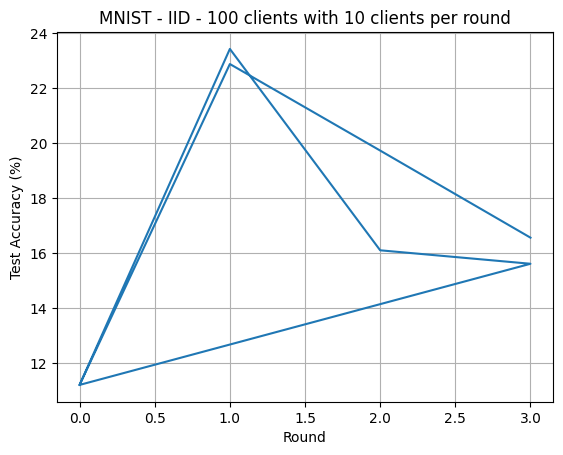

In [ ]:
global_accuracy_centralised = history["accuracy"]
round = [data[1] for data in global_accuracy_centralised]
acc = [100.0 * data[0] for data in global_accuracy_centralised]
plt.plot(round, acc)
plt.grid()
plt.ylabel("Test Accuracy (%)")
plt.xlabel("Round")
plt.title("MNIST - IID - 100 clients with 10 clients per round")

Text(0.5, 1.0, 'MNIST - IID - 100 clients with 10 clients per round')

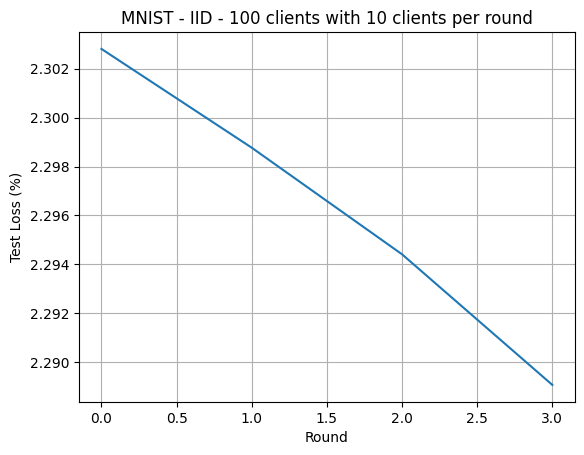

In [ ]:
global_loss_centralised = history["loss"]
round = [data[1] for data in global_loss_centralised]
loss = [100.0 * data[0] for data in global_loss_centralised]
plt.plot(round, loss)
plt.grid()
plt.ylabel("Test Loss (%)")
plt.xlabel("Round")
plt.title("MNIST - IID - 100 clients with 10 clients per round")

In [ ]:
history

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


{'accuracy': [(0.112, 0), (0.2343, 1), (0.161, 2), (0.1561, 3)],
 'loss': [(0.0230280880689621, 0),
  (0.02298769462108612, 1),
  (0.02294411289691925, 2),
  (0.022890711307525635, 3)]}